<a href="https://colab.research.google.com/github/ShawBin24/RocketAcademyBasics/blob/main/CarBrand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CH4244 Python Assignment Part 2**
Name: Yap Shaw Bin

>


Matriculation Number: U1920670F

# Classification of car brands (Problem Statement)

Given a dataset that consists of car images from five different brands (BMW, Bugatti,
Lamborghini, McLaren, and Volkswagen), your task is to design a neural network using
Tensorflow Keras that can classify those vehicles' images into their corresponding brands.
The dataset is available at
https://app.box.com/shared/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip.

### Import Modules

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.constraints import max_norm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from keras import callbacks
import os
import zipfile
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### **(a) Load the data and then preprocess them with ImageDataGenerator().**

Firstly, a .zip of 600 JPG pictures of cars are downloaded as our example data and extracted locally in /tmp.

In [ ]:
!wget --no-check-certificate \
    https://app.box.com/shared/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip \
    -O /tmp/cars.zip

--2022-11-16 03:06:04--  https://app.box.com/shared/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip
Resolving app.box.com (app.box.com)... 74.112.186.144
Connecting to app.box.com (app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip [following]
--2022-11-16 03:06:05--  https://app.box.com/public/static/bgjqppjtnbc8e7258rbnq0ch7fy27tp6.zip
Reusing existing connection to app.box.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://dl2.boxcloud.com/d/1/b1!ba_fWk71WzHK1XTsuphCYUu5apTrPPiBkgsbOTM49Z1bodWhlCJSh8Pv51cZFYJkPVWhWRZNl8rfvRmhvQOA8SvKQgYzjNqXlB_OmbNrZ4WgS0tfNdHRnklbN3WyOKbu-e267wMZat7n69hkeY09a_iGqcBbhDcxTiaDEBFzViwccgAPsDxKeNGTKjBXxq6Do4YhNexgSVh4VSB549vZ8Sc7bxSKmp7Z3AkD1UeDId2m6ZC0uw7wCeJveu3iq0mNPrdzlukeDhgFPsad_c_N_32z4h6AzvlJFbR-wRYhDYW9d58Ct9BZ51OQ3o2L0nOdDrTRafROtQ_PatqfiYHw4FmYsAb549rX4Top_D0568F1c2dTPUOktE0B1QmYOxqGH1xI_vsR0hNdVUAcRKDB

After downloading the .zip file of the data, the image dataset is unzipped and the folder structure is reorganized.

In [ ]:
local_zip = '/tmp/cars.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
base_path = '/tmp/cars'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

As Inceptionv3 model (GoogLeNet) is going to be used for transfer learning and construction of the CNN model, image dataset is preprocessed using inception_v3.preprocess_input function. 

In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(299,299), classes=['BMW', 'Bugatti','Lamborghini','McLaren','Volkswagen'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(299,299), classes=['BMW', 'Bugatti','Lamborghini','McLaren','Volkswagen'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(299,299), classes=['BMW', 'Bugatti','Lamborghini','McLaren','Volkswagen'], batch_size=10, shuffle = False)

Found 400 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [ ]:
imgs, labels = next(train_batches)

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

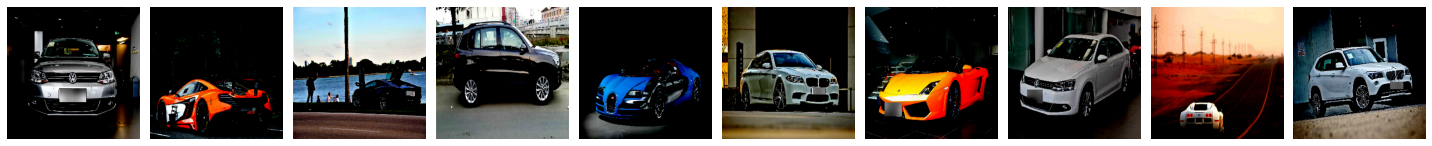

[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [ ]:
plotImages(imgs)
print(labels)

### **(b) Build a convolutional neural network either from scratch or existing models.**

From the summary of InceptionV3 model, last two layers are referring to the last fully connected layer and predictions layer, which is specific to the ImageNet competition. Hence, all the previous layers are extracted for the proposed model except the last two layers. 

In [ ]:
# Import InceptionV3 model
inception_v3 = tf.keras.applications.inception_v3.InceptionV3(include_top=False, # drop the prediction layer
                                                              weights = 'imagenet', # use the parameters trained from the imagenet dataset
                                                              input_shape = (299,299,3))

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for layer in inception_v3.layers:
    layer.trainable = False

In [ ]:
model = Sequential([
    inception_v3,
    # Flatten the output layer to  1 dimension
    Flatten(),
    # Add a fully connected layer with 1024 hidden units and ReLU activation
    Dense(1024, activation = 'relu'),
    # Add a dropout layer with rate 0.3
    Dropout(0.3),
    # Add a final softmax layer for the classification process 
    Dense(5, activation = 'softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = [keras.metrics.CategoricalAccuracy()])

### **(c) Train the neural network, evaluate the model prediction, and obtain the evaluation metrics, including prediction accuracy and confusion matrix.**

In [ ]:
model.fit(x=train_batches, validation_data=valid_batches, epochs = 5, verbose=2)

Epoch 1/5
40/40 - 89s - loss: 3.1301 - categorical_accuracy: 0.5400 - val_loss: 3.1355 - val_categorical_accuracy: 0.6300 - 89s/epoch - 2s/step
Epoch 2/5


KeyboardInterrupt: ignored

In [ ]:
y_test = test_batches.classes
print(y_test)

In [ ]:
output_layer = model.predict(x=test_batches, verbose=0)
output = tf.one_hot(tf.argmax(output_layer, axis=1), output_layer.shape[1], on_value=1, off_value=0)

In [ ]:
y_pred = np.argmax(output, axis=-1)
print(y_pred)

In [ ]:
print(metrics.classification_report(y_test, y_pred, digits=3))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BMW', 'Bugatti','Lamborghini','McLaren','Volkswagen'])
plt.rcParams['figure.figsize'] = [10, 10]
disp.plot(cmap=plt.cm.Blues)
plt.show()

### **(d) Based on error analysis and online materials, suggest a proper direction that can lead to better performance of your model in your presentation document.**

add maxnorm regularization term + modify dropout rate to 0.2 + more epochs required - leading to the need of callback 

Decent accuracy, but perhaps the difference between training set accuracy and validation set accuracy indicates that overfitting has occurred.

Consistency Testing

In [ ]:
ct_accuracy=[]
for i in range(5):
  model = Sequential([
    inception_v3,
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(0.3),
    Dense(5, activation = 'softmax')
    ])
  model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = [keras.metrics.CategoricalAccuracy()])
  model.fit(x=train_batches, validation_data=valid_batches, epochs = 5, verbose=0)
  _, accuracy = model.evaluate(test_batches)
  ct_accuracy.append([accuracy])

print('Max accuracy:',max(ct_accuracy))
print('Min accuracy:',min(ct_accuracy))

### **(e) Implement the new direction suggested in (d) and demonstrate better evaluation metrics in your prediction outcome.**

In [ ]:
model2 = Sequential([
    inception_v3,
    Flatten(),
    Dense(1024, activation = 'relu', kernel_constraint=max_norm(3)),
    Dropout(0.2),
    Dense(5, activation = 'softmax', kernel_constraint=max_norm(3))
    ])

model2.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = [keras.metrics.CategoricalAccuracy()])

earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True)

history = model2.fit(x=train_batches, validation_data=valid_batches, epochs = 50, verbose=2, callbacks =[earlystopping])

In [ ]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [ ]:
y_test = test_batches.classes
output_layer = model2.predict(x=test_batches, verbose=0)
output = tf.one_hot(tf.argmax(output_layer, axis=1), output_layer.shape[1], on_value=1, off_value=0)
y_pred = np.argmax(output, axis=-1)
print(metrics.classification_report(y_test, y_pred, digits=3))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BMW', 'Bugatti','Lamborghini','McLaren','Volkswagen'])
plt.rcParams['figure.figsize'] = [10, 10]
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
ct_accuracy2=[]
for i in range(5):
  model2 = Sequential([
    inception_v3,
    Flatten(),
    Dense(1024, activation = 'relu', kernel_constraint=max_norm(3)),
    Dropout(0.2),
    Dense(5, activation = 'softmax', kernel_constraint=max_norm(3))
    ])
 
  model2.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = [keras.metrics.CategoricalAccuracy()])

  earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True)
  
  model2.fit(x=train_batches, validation_data=valid_batches, epochs = 50, verbose=0, callbacks =[earlystopping])
  _, accuracy = model2.evaluate(test_batches)
  ct_accuracy2.append([accuracy])

print('Max accuracy:',max(ct_accuracy2))
print('Min accuracy:',min(ct_accuracy2))